In [4]:
import sys
print(sys.path)
sys.path.append("/Users/boykoborisov/Desktop/ETH/deltazip/")
print(sys.path)


['/Users/boykoborisov/Desktop/ETH/deltazip/notebooks', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python311.zip', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload', '', '/Users/boykoborisov/Library/Python/3.11/lib/python/site-packages', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages']
['/Users/boykoborisov/Desktop/ETH/deltazip/notebooks', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python311.zip', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload', '', '/Users/boykoborisov/Library/Python/3.11/lib/python/site-packages', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages', '/Users/boykoborisov/Desktop/ETH/deltazip/']


In [5]:
import torch
from transformers import AutoModelForCausalLM, AutoConfig
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import count_nonzero
from deltazip import AutoDeltaZipModelForCausalLM

def calculate_sparsity(tensor):
    return 1.0 - (count_nonzero(tensor) / float(tensor.size))

ModuleNotFoundError: No module named 'cupy'

In [9]:
model = AutoModelForCausalLM.from_pretrained(f"mlabonne/phixtral-2x2_8", trust_remote_code=True)

In [3]:
AutoConfig.from_pretrained(f"mlabonne/phixtral-2x2_8", trust_remote_code=True).model_type

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.


'phi-msft'

In [ ]:
delta_model = AutoDeltaZipModelForCausalLM.from_pretrained("mlabonne/phixtral-2x2_8")

In [ ]:
 for module_name in self.outside_layer_modules:
  module = get_module_by_name(self.model, module_name)

In [17]:
print(model)

PhiForCausalLM(
  (transformer): PhiModel(
    (embd): Embedding(
      (wte): Embedding(51200, 2560)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (h): ModuleList(
      (0-31): 32 x ParallelBlock(
        (ln): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
        (mixer): MHA(
          (rotary_emb): RotaryEmbedding()
          (Wqkv): Linear(in_features=2560, out_features=7680, bias=True)
          (out_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (inner_attn): SelfAttention(
            (drop): Dropout(p=0.0, inplace=False)
          )
          (inner_cross_attn): CrossAttention(
            (drop): Dropout(p=0.0, inplace=False)
          )
        )
        (moe): MoE(
          (mlp): ModuleList(
            (0-1): 2 x MLP(
              (fc1): Linear(in_features=2560, out_features=10240, bias=True)
              (fc2): Linear(in_features=10240, out_features=2560, bias=True)
     

In [7]:
print([k for k, _ in model.named_modules()])

['', 'transformer', 'transformer.embd', 'transformer.embd.wte', 'transformer.embd.drop', 'transformer.h', 'transformer.h.0', 'transformer.h.0.ln', 'transformer.h.0.resid_dropout', 'transformer.h.0.mixer', 'transformer.h.0.mixer.rotary_emb', 'transformer.h.0.mixer.Wqkv', 'transformer.h.0.mixer.out_proj', 'transformer.h.0.mixer.inner_attn', 'transformer.h.0.mixer.inner_attn.drop', 'transformer.h.0.mixer.inner_cross_attn', 'transformer.h.0.mixer.inner_cross_attn.drop', 'transformer.h.0.moe', 'transformer.h.0.moe.mlp', 'transformer.h.0.moe.mlp.0', 'transformer.h.0.moe.mlp.0.fc1', 'transformer.h.0.moe.mlp.0.fc2', 'transformer.h.0.moe.mlp.0.act', 'transformer.h.0.moe.mlp.1', 'transformer.h.0.moe.mlp.1.fc1', 'transformer.h.0.moe.mlp.1.fc2', 'transformer.h.0.moe.mlp.1.act', 'transformer.h.0.moe.gate', 'transformer.h.1', 'transformer.h.1.ln', 'transformer.h.1.resid_dropout', 'transformer.h.1.mixer', 'transformer.h.1.mixer.rotary_emb', 'transformer.h.1.mixer.Wqkv', 'transformer.h.1.mixer.out_pro

In [3]:
# See the model state dict keys to identify the target layers
print("\n".join(model.state_dict().keys()))

transformer.embd.wte.weight
transformer.h.0.ln.weight
transformer.h.0.ln.bias
transformer.h.0.mixer.Wqkv.weight
transformer.h.0.mixer.Wqkv.bias
transformer.h.0.mixer.out_proj.weight
transformer.h.0.mixer.out_proj.bias
transformer.h.0.moe.mlp.0.fc1.weight
transformer.h.0.moe.mlp.0.fc1.bias
transformer.h.0.moe.mlp.0.fc2.weight
transformer.h.0.moe.mlp.0.fc2.bias
transformer.h.0.moe.mlp.1.fc1.weight
transformer.h.0.moe.mlp.1.fc1.bias
transformer.h.0.moe.mlp.1.fc2.weight
transformer.h.0.moe.mlp.1.fc2.bias
transformer.h.0.moe.gate.weight
transformer.h.1.ln.weight
transformer.h.1.ln.bias
transformer.h.1.mixer.Wqkv.weight
transformer.h.1.mixer.Wqkv.bias
transformer.h.1.mixer.out_proj.weight
transformer.h.1.mixer.out_proj.bias
transformer.h.1.moe.mlp.0.fc1.weight
transformer.h.1.moe.mlp.0.fc1.bias
transformer.h.1.moe.mlp.0.fc2.weight
transformer.h.1.moe.mlp.0.fc2.bias
transformer.h.1.moe.mlp.1.fc1.weight
transformer.h.1.moe.mlp.1.fc1.bias
transformer.h.1.moe.mlp.1.fc2.weight
transformer.h.1.moe

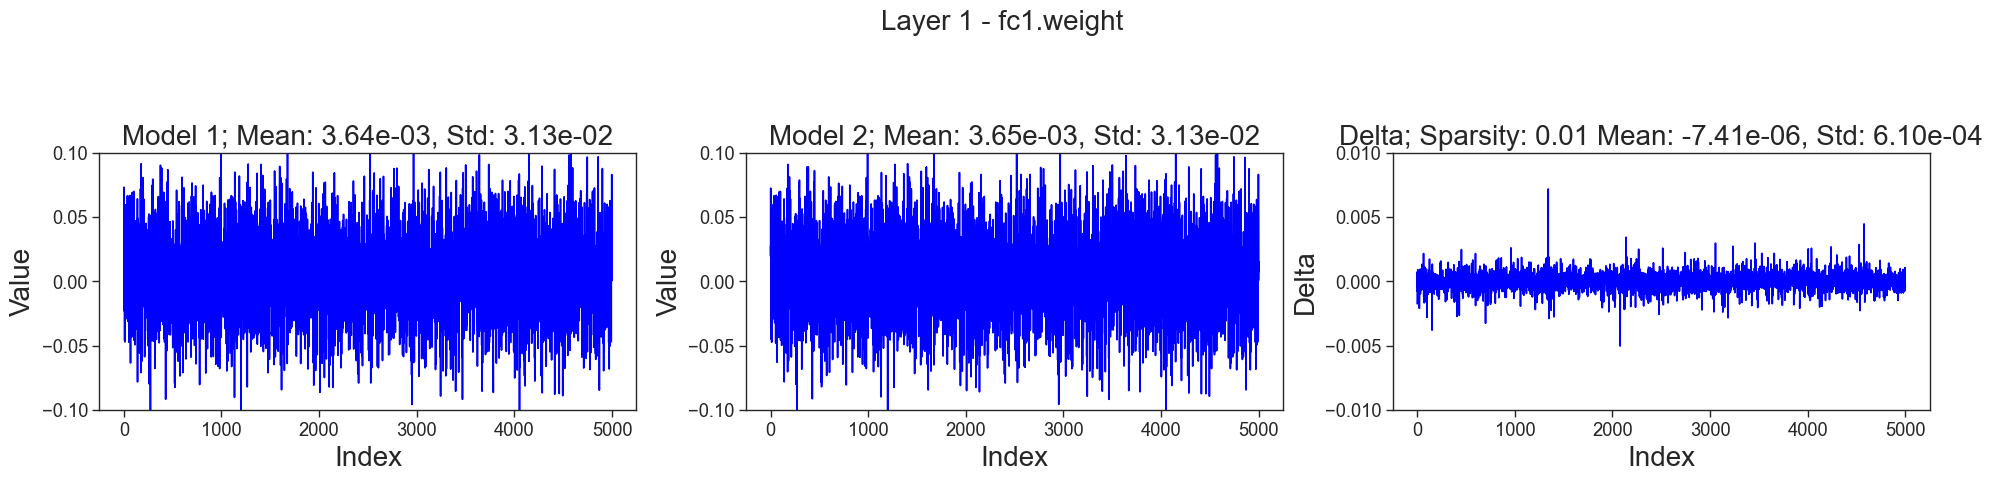

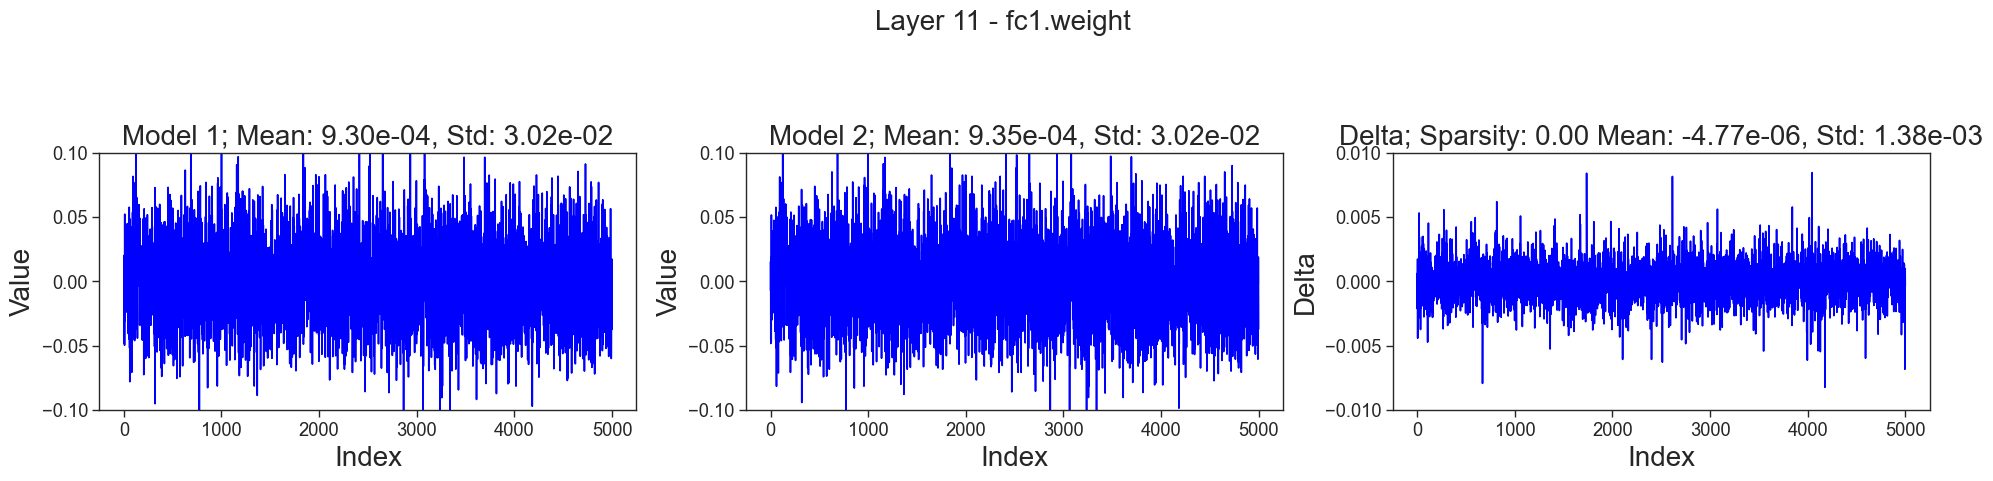

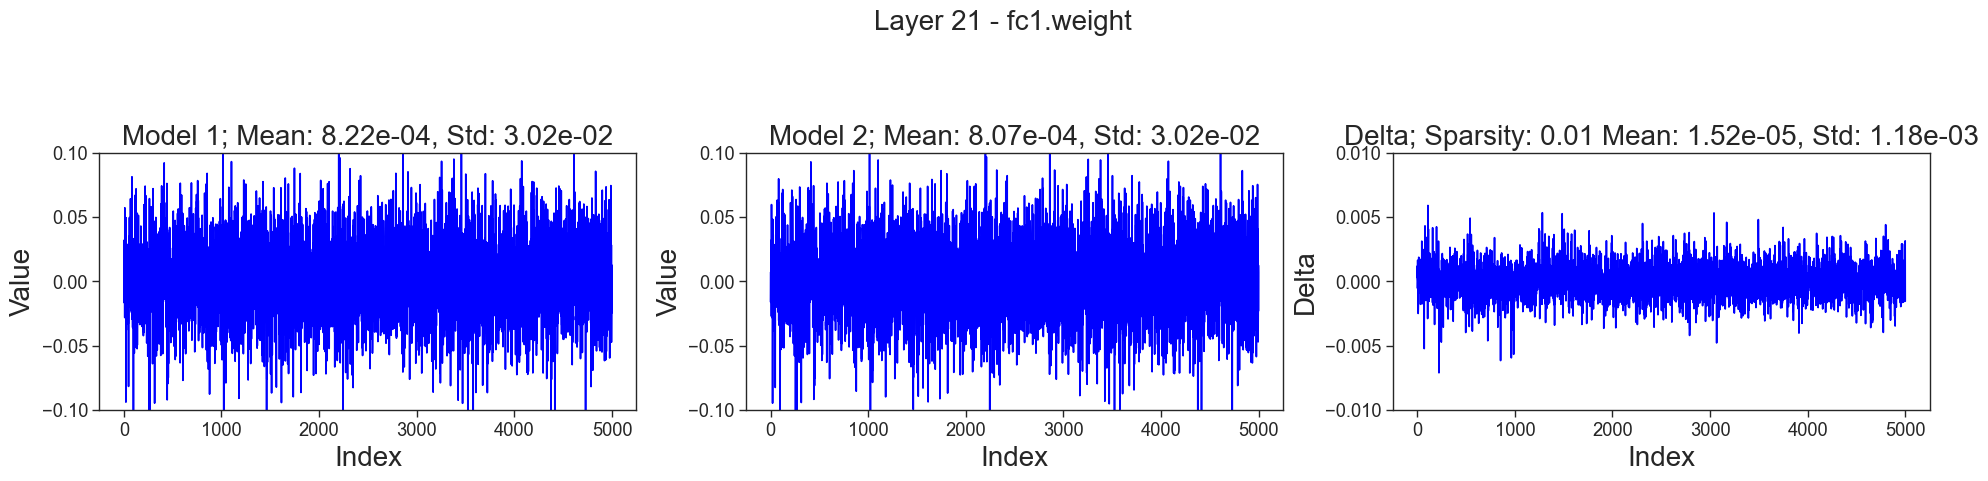

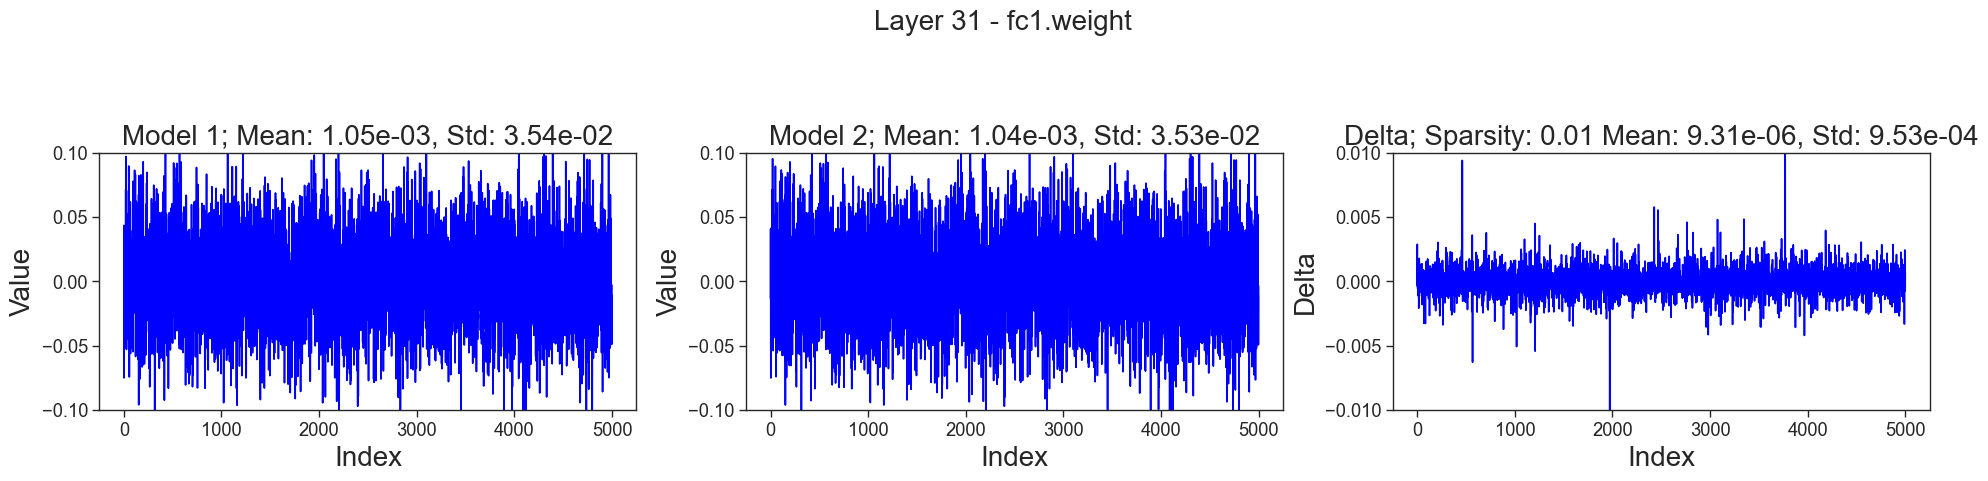

In [34]:
layers = [1, 11, 21, 31]
for layer in layers:
      focus_name_net_1 = f"transformer.h.{layer}.moe.mlp.0.fc1.weight"
      focus_name_net_2 = f"transformer.h.{layer}.moe.mlp.1.fc1.weight"

      weight_1 = model.state_dict()[focus_name_net_1].flatten().cpu().numpy()
      weight_2 = model.state_dict()[focus_name_net_2].flatten().cpu().numpy()
      delta_weight = weight_1 - weight_2
      
      sample_size = 5000
      sampled_indices = np.random.choice(
        len(weight_1), size=sample_size, replace=False
      )

      weight_1 = weight_1[sampled_indices]
      weight_2 = weight_2[sampled_indices]
      delta_weight = delta_weight[sampled_indices]

      sns.set_theme(style="whitegrid")
      sns.set(rc={"figure.figsize": (11.7, 8.27)})
      sns.set(font_scale=1.5)
      sns.set_style("ticks")
      sns.set_context("paper", font_scale=1.5)
      
      fig, axs = plt.subplots(1, 3, figsize=(20, 5))
      fig.suptitle(f"Layer {layer} - fc1.weight", fontsize=20)
      fig.tight_layout(pad=3.0)

      sns.lineplot(ax=axs[0], data=weight_1, color="blue")
      axs[0].set_title(
        f"Model 1; Mean: {np.mean(weight_1):.2e}, Std: {np.std(weight_1):.2e}",
        fontsize=20,
      )
      axs[0].set_xlabel("Index", fontsize=20)
      axs[0].set_ylabel("Value", fontsize=20)
      axs[0].set_ylim((-0.1, 0.1))

      sns.lineplot(ax=axs[1], data=weight_2, color="blue")
      axs[1].set_title(
        f"Model 2; Mean: {np.mean(weight_2):.2e}, Std: {np.std(weight_2):.2e}",
        fontsize=20,
      )
      axs[1].set_xlabel("Index", fontsize=20)
      axs[1].set_ylabel("Value", fontsize=20)
      axs[1].set_ylim((-0.1, 0.1))

      sns.lineplot(ax=axs[2], data=delta_weight, color="blue")
      axs[2].set_title(
        f"Delta; Sparsity: {calculate_sparsity(delta_weight):.2f} Mean: {np.mean(delta_weight):.2e}, Std: {np.std(delta_weight):.2e}",
        fontsize=20,
      )
      axs[2].set_xlabel("Index", fontsize=20)
      axs[2].set_ylabel("Delta", fontsize=20)
      axs[2].set_ylim((-0.01, 0.01))
      plt.show()


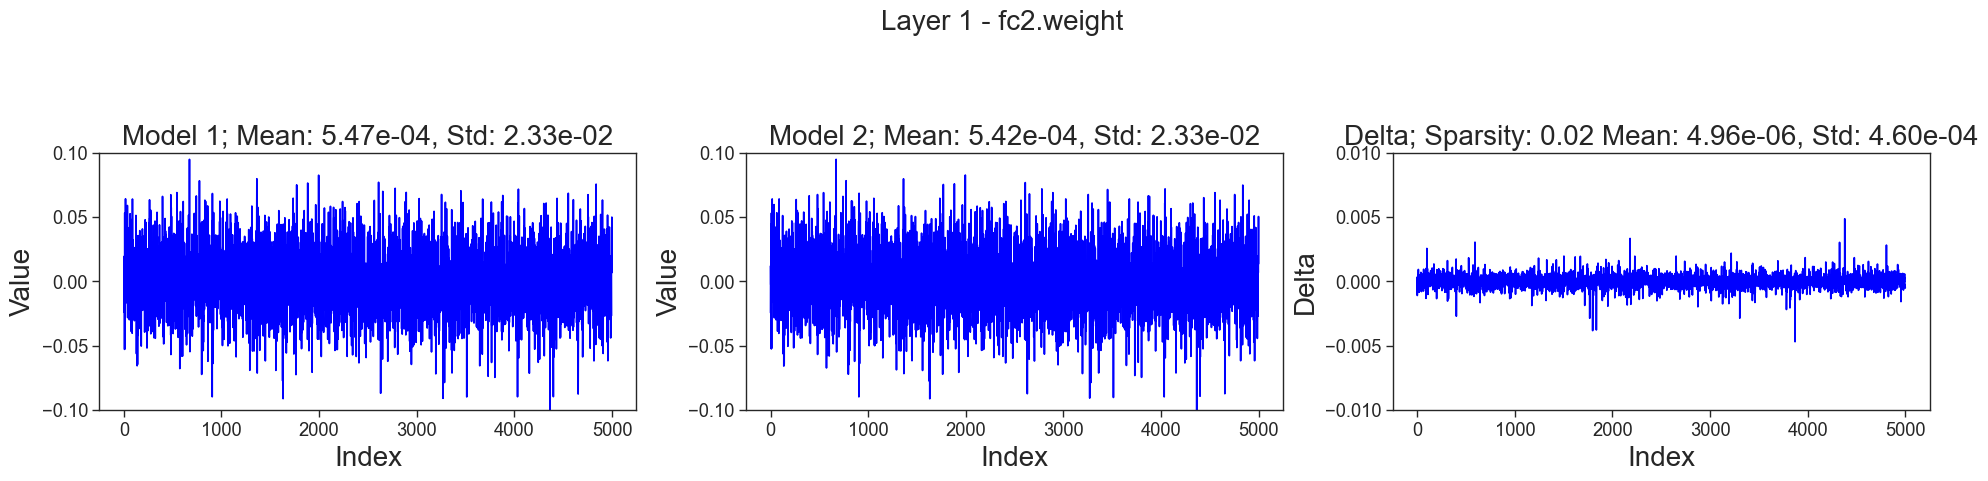

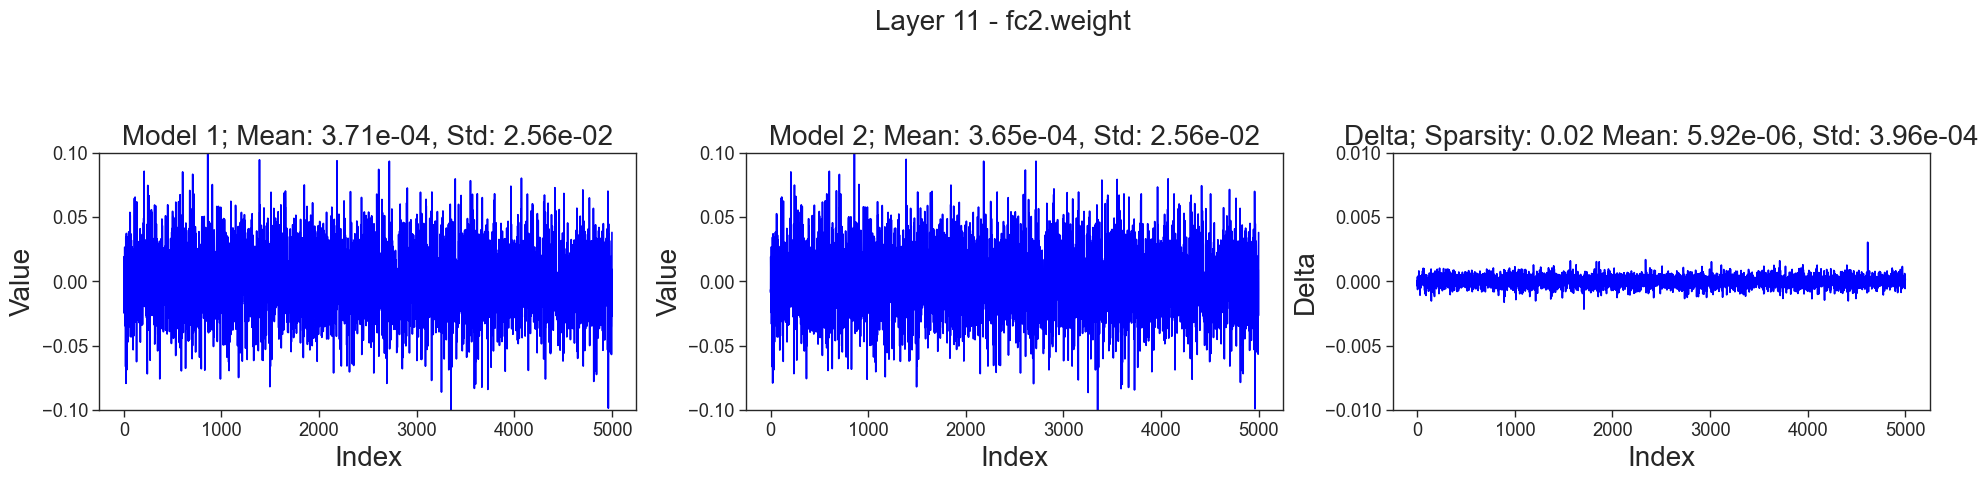

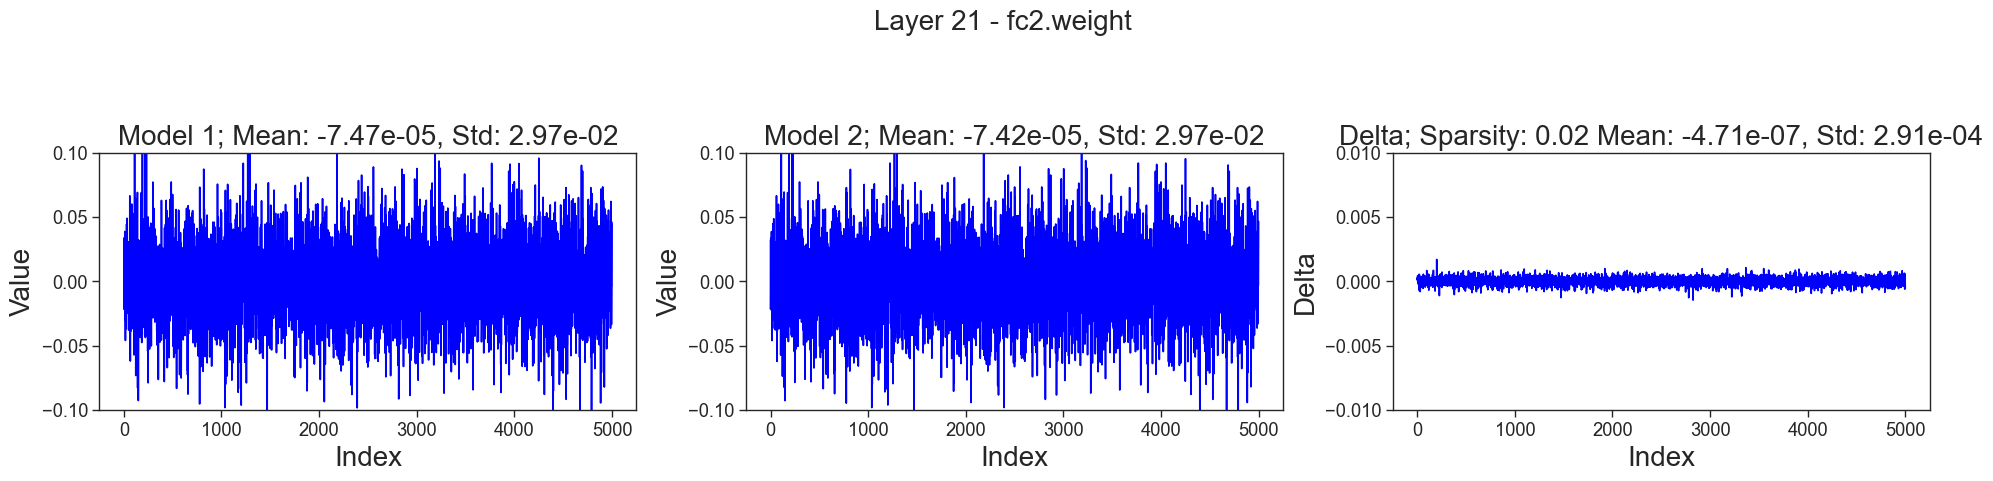

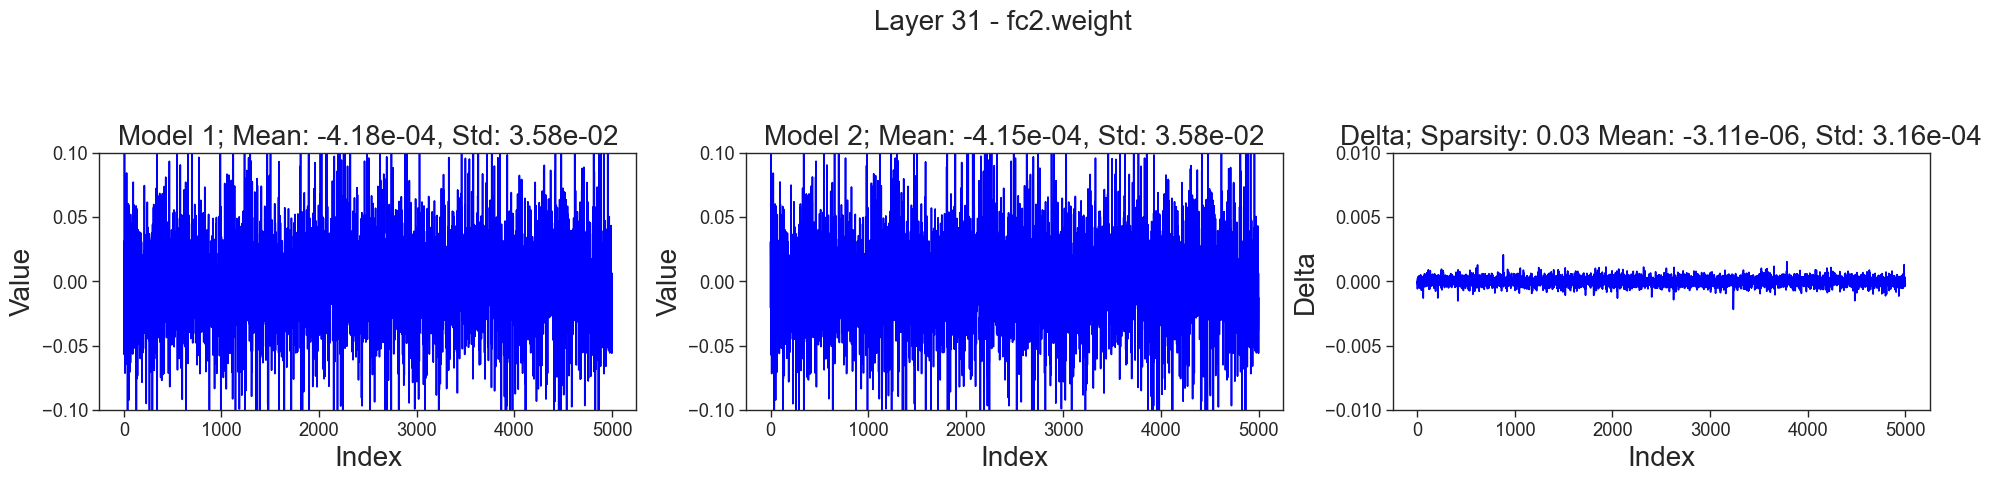

In [35]:
layers = [1, 11, 21, 31]
for layer in layers:
      focus_name_net_1 = f"transformer.h.{layer}.moe.mlp.0.fc2.weight"
      focus_name_net_2 = f"transformer.h.{layer}.moe.mlp.1.fc2.weight"

      weight_1 = model.state_dict()[focus_name_net_1].flatten().cpu().numpy()
      weight_2 = model.state_dict()[focus_name_net_2].flatten().cpu().numpy()
      delta_weight = weight_1 - weight_2
      
      sample_size = 5000
      sampled_indices = np.random.choice(
        len(weight_1), size=sample_size, replace=False
      )

      weight_1 = weight_1[sampled_indices]
      weight_2 = weight_2[sampled_indices]
      delta_weight = delta_weight[sampled_indices]

      sns.set_theme(style="whitegrid")
      sns.set(rc={"figure.figsize": (11.7, 8.27)})
      sns.set(font_scale=1.5)
      sns.set_style("ticks")
      sns.set_context("paper", font_scale=1.5)
      
      fig, axs = plt.subplots(1, 3, figsize=(20, 5))
      fig.suptitle(f"Layer {layer} - fc2.weight", fontsize=20)
      fig.tight_layout(pad=3.0)

      sns.lineplot(ax=axs[0], data=weight_1, color="blue")
      axs[0].set_title(
        f"Model 1; Mean: {np.mean(weight_1):.2e}, Std: {np.std(weight_1):.2e}",
        fontsize=20,
      )
      axs[0].set_xlabel("Index", fontsize=20)
      axs[0].set_ylabel("Value", fontsize=20)
      axs[0].set_ylim((-0.1, 0.1))

      sns.lineplot(ax=axs[1], data=weight_2, color="blue")
      axs[1].set_title(
        f"Model 2; Mean: {np.mean(weight_2):.2e}, Std: {np.std(weight_2):.2e}",
        fontsize=20,
      )
      axs[1].set_xlabel("Index", fontsize=20)
      axs[1].set_ylabel("Value", fontsize=20)
      axs[1].set_ylim((-0.1, 0.1))

      sns.lineplot(ax=axs[2], data=delta_weight, color="blue")
      axs[2].set_title(
        f"Delta; Sparsity: {calculate_sparsity(delta_weight):.2f} Mean: {np.mean(delta_weight):.2e}, Std: {np.std(delta_weight):.2e}",
        fontsize=20,
      )
      axs[2].set_xlabel("Index", fontsize=20)
      axs[2].set_ylabel("Delta", fontsize=20)
      axs[2].set_ylim((-0.01, 0.01))
      plt.show()
